# Моделирование 2 лабораторная работа

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal, getcontext
from scipy.integrate import solve_ivp
getcontext().prec =70

## Исходные данные

In [83]:
R = 0.35
Tw = 2000
T0 = 10000
p = 4
c = 3e10

z = np.linspace(0, 1, 1000)

table_kt = np.array([
    [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    [8.200e-3, 2.768e-2, 6.560e-2, 1.281e-1, 2.214e-1, 3.516e-1, 5.248e-1, 7.472e-1, 1.025e0],
    [1.600e0, 5.400e0, 1.280e1, 2.500e1, 4.320e1, 6.860e1, 1.024e2, 1.458e2, 2.000e2]
])

table_kt_log = np.log(table_kt)

print(table_kt)

[[2.000e+03 3.000e+03 4.000e+03 5.000e+03 6.000e+03 7.000e+03 8.000e+03
  9.000e+03 1.000e+04]
 [8.200e-03 2.768e-02 6.560e-02 1.281e-01 2.214e-01 3.516e-01 5.248e-01
  7.472e-01 1.025e+00]
 [1.600e+00 5.400e+00 1.280e+01 2.500e+01 4.320e+01 6.860e+01 1.024e+02
  1.458e+02 2.000e+02]]


## Интерполяции таблицы k(T) - коэффициент поглощения

In [84]:
k_1 = (table_kt_log[1][-1] - table_kt_log[1][0]) / (table_kt_log[0][-1] - table_kt_log[0][0])
b_1 = (table_kt_log[1][0] - table_kt_log[0][0] * k_1)

k_2 = (table_kt_log[2][-1] - table_kt_log[2][0]) / (table_kt_log[0][-1] - table_kt_log[0][0])
b_2 = (table_kt_log[2][0] - table_kt_log[0][0] * k_1)

print(f"ln(k) = {round(k_1, 3)} * ln(T) + {round(b_1, 3)}")
print(f"ln(k) = {round(k_2, 3)} * ln(T) + {round(b_2, 3)}")

ln(k) = 3.0 * ln(T) + -27.606
ln(k) = 3.0 * ln(T) + -22.333


In [85]:
def k1(T):
    return np.exp(k_1 * np.log(T) + b_1)

def k2(T):
    return np.exp(k_2 * np.log(T) + b_2)

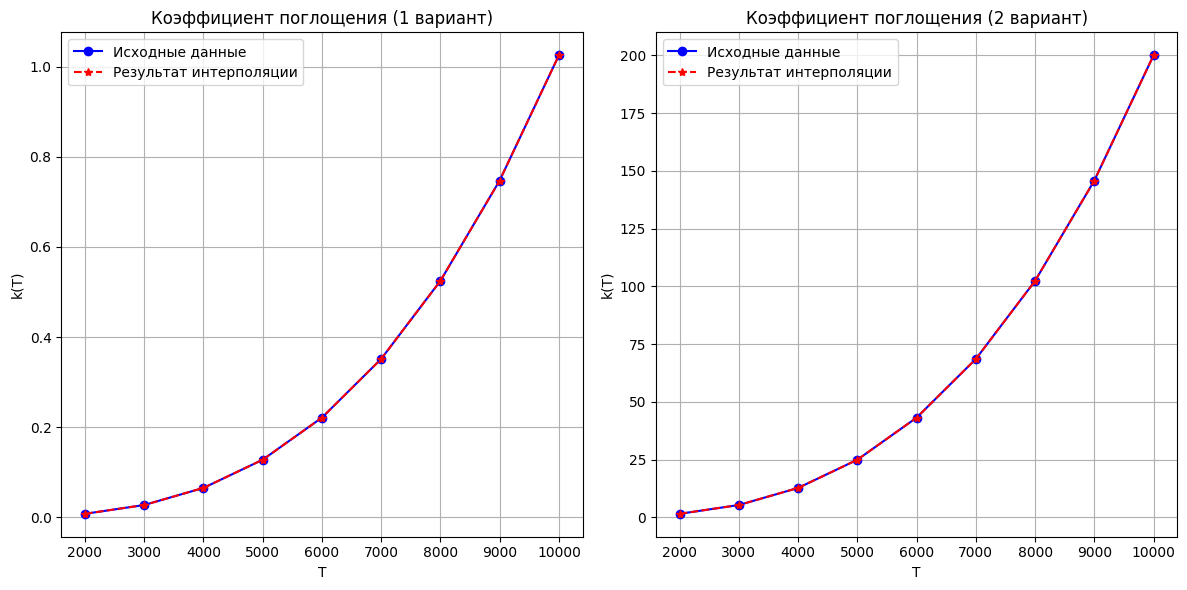

In [86]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(table_kt[0], table_kt[1], marker='o', linestyle='-', color='b', label="Исходные данные")
plt.plot(table_kt[0], k1(table_kt[0]), marker='*', linestyle='--', color='r', label="Результат интерполяции")
plt.title('Коэффициент поглощения (1 вариант)')
plt.xlabel('T')
plt.ylabel('k(T)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(table_kt[0], table_kt[2], marker='o', linestyle='-', color='b', label="Исходные данные")
plt.plot(table_kt[0], k2(table_kt[0]), marker='*', linestyle='--', color='r', label="Результат интерполяции")
plt.title('Коэффициент поглощения (2 вариант)')
plt.xlabel('T')
plt.ylabel('k(T)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## T(z) - температурное поле в цилинде, вывод графика k(T(z))

In [87]:
def T(z):
    return (Tw - T0) * z ** p + T0

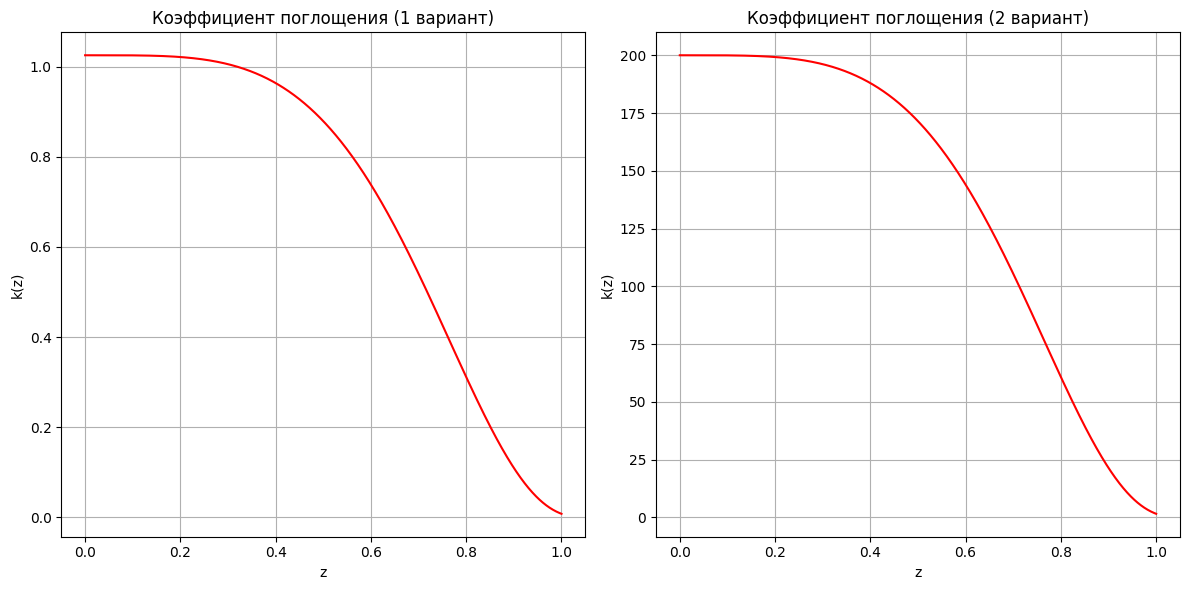

In [88]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(z, k1(T(z)), linestyle='-', color='r')
plt.title('Коэффициент поглощения (1 вариант)')
plt.xlabel('z')
plt.ylabel('k(z)')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(z, k2(T(z)), linestyle='-', color='r')
plt.title('Коэффициент поглощения (2 вариант)')
plt.xlabel('z')
plt.ylabel('k(z)')
plt.grid()

plt.tight_layout()
plt.show()

## Up(z) - функция Планка

In [89]:
def Up(z):
    return Decimal("3.084e-4") / (np.exp(Decimal("4.799e4") / Decimal(T(z))) - Decimal("1"))

In [90]:
def Up2(z):
    return 3.084e-4 / (np.exp(4.799e4 / T(z)) - 1)

## Производные dU и dF

In [91]:
def dU(z, F):
    return Decimal("-3") * Decimal(R) * Decimal(k2(T(z))) * F / Decimal(c)

In [92]:
def dF(z, u, F):
    part = Decimal(c) * Decimal(k2(T(z))) * (Up(z) - u) * Decimal(R)
    return part / Decimal("2") if z == 0 else part - F / Decimal(z)

In [93]:
def equations(z, y):
    u, F = y
    part = c * k2(T(z)) * (float(Up(z)) - u) * R
    return [
        -3 * R * k2(T(z)) * F / c,
        part / 2 if z == 0 else part - F / z
    ]

## Методы Рунге-Кутты 2-го и 4-го порядков

In [94]:
def RungeKutt2(ksi):
    
    step = 1 / len(z)

    u = np.zeros(len(z))
    F = np.zeros(len(z))
    
    u[0] = ksi * Up(0)

    for i in range(len(z) - 1):

        k1 = dU(z[i], F[i])
        l1 = dF(z[i], u[i], F[i])

        k2 = dU(z[i] + step / 2, F[i] + step / 2 * l1)
        l2 = dF(z[i] + step / 2, u[i] + step / 2 * k1, F[i] + step / 2 * l1)
        
        u[i + 1] =  u[i] + step * k2
        F[i + 1] =  F[i] + step * l2

    return u, F

def RungeKutt4(ksi):
    
    step = 1 / len(z)
    dec_step = Decimal(1 / len(z))

    u = np.array([Decimal(0) for _ in range(len(z))])
    F = np.array([Decimal(0) for _ in range(len(z))])

    u[0] = ksi * Up(0)

    for i in range(len(z) - 1):

        k1 = dU(z[i], F[i])
        l1 = dF(z[i], u[i], F[i])

        k2 = dU(z[i] + step / 2, F[i] + dec_step / Decimal("2") * l1)
        l2 = dF(z[i] + step / 2, u[i] + dec_step / Decimal("2") * k1, F[i] + dec_step / Decimal("2") * l1)

        k3 = dU(z[i] + step / 2, F[i] + dec_step / Decimal("2") * l2)
        l3 = dF(z[i] + step / 2, u[i] + dec_step / Decimal("2") * k2, F[i] + dec_step / Decimal("2") * l2)

        k4 = dU(z[i] + step, F[i] + dec_step * l3)
        l4 = dF(z[i] + step, u[i] + dec_step * k3, F[i] + dec_step * l3)
        
        u[i + 1] =  u[i] + dec_step * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        F[i + 1] =  F[i] + dec_step * (l1 + 2 * l2 + 2 * l3 + l4) / 6

    return u, F

def IVP(ksi):
    
    initial_conditions = [float(ksi * Up(0)), 0]
    
    sol = solve_ivp(equations, (0, 1), initial_conditions, t_eval=z, method='BDF')
        
    return sol.y[0], sol.y[1]

## Методы стрельбы и дихотомии

In [95]:
def PSI(ksi, func):
    u, F = func(ksi)

    return Decimal("0.393") * Decimal(c) * Decimal(u[-1]) - Decimal(F[-1])

In [96]:
def DichotomyMethod(func):
    length = 1000

    psi = np.array([Decimal(0) for _ in range(length)])
    ksi = np.array([Decimal(0) for _ in range(length)])

    ksi[0] = Decimal(0.9)
    ksi[1] = Decimal(1)
    psi[0] = PSI(ksi[0], func)
    psi[1] = PSI(ksi[1], func)

    left = Decimal(0)
    right = Decimal(0)

    i = 1
    # while np.abs((ksi[i] - ksi[i - 1]) / ksi[i]) > Decimal("1e-16") or np.abs(psi[i]) > Decimal("1e-3"):
    while np.abs((ksi[i] - ksi[i - 1]) / ksi[i]) > Decimal("1e-40"):
        
        left = ksi[i]
        right = ksi[i - 1]

        ksi[i + 1] = (ksi[i] + ksi[i - 1]) / Decimal(2)
        psi[i + 1] = PSI(ksi[i + 1], func)

        print(float(ksi[i + 1]), float(psi[i + 1]))
        
        if psi[i - 1] * psi[i + 1] < 0:
            left, right = ksi[i - 1], ksi[i]
            ksi[i] = ksi[i - 1]
            psi[i] = psi[i - 1]
            
        elif psi[i + 1] == Decimal(0):
            i += 1
            break

        i += 1

    u, F = func(ksi[i])

    return left if left < right else right, ksi[i], right if right > left else left, u, F

## Результаты

In [97]:
ksi_left, ksi, ksi_right, u, F = DichotomyMethod(RungeKutt4)

# df = pd.DataFrame({'z': np.round(z, 2), 'u(z)': np.round(u, 10), 'F(z)': np.round(F, 2)})
# print(df)

print(f"\nFmax = {max(F)}")

print(f"\nЗначение параметра ξ: {round(ksi, 7)}")
print(f"Диапозон параметра ξ: ({round(ksi_left, 7)}; {round(ksi_right, 7)})")

0.95 -4.290153516483064e+38
0.975 -2.1450274094416553e+38
0.9875 -1.072464355920951e+38
0.99375 -5.361828291605987e+37
0.996875 -2.680420657804226e+37
0.9984375 -1.3397168409033456e+37
0.99921875 -6.693649324529054e+36
0.999609375 -3.341889782276852e+36
0.9998046875 -1.6660100111507514e+36
0.99990234375 -8.280701255877013e+35
0.999951171875 -4.0910018280617616e+35
0.9999755859375 -1.9961521141541355e+35
0.99998779296875 -9.487272572003227e+34
0.999993896484375 -4.250148287234163e+34
0.9999969482421875 -1.631586144849631e+34
0.9999984741210938 -3.223050736573649e+33
0.9999992370605468 3.323354619387681e+33
0.9999988555908204 5.0151941407016115e+31
0.999998664855957 -1.5864493975833165e+33
0.9999987602233886 -7.681487280881501e+32
0.9999988079071045 -3.5899839334056704e+32
0.9999988317489624 -1.5442322596677546e+32
0.9999988436698913 -5.213564227987967e+31
0.9999988496303558 -9.918504364317769e+29
0.9999988526105881 2.458004548529217e+31
0.9999988511204719 1.1794097524430198e+31
0.999998

In [98]:
print(u[0], "\n", F[0], "\n", u[-1], "\n", F[-1])

0.000002561693573794169780979943150447689912882190618168571846600422404190768 
 0 
 3.126795336153663068399387755375154805224699896227894452200049778178795E-8 
 368.7210143875265872294421370618239813725150474666797363873893961611181


In [99]:
h = 1 / len(z)

I = Decimal(h) * (Decimal(k2(T(1))) * (Up(1) - u[-1])) / Decimal("2")

for i in range(len(z) - 1):
    I += Decimal(k2(T(z[i]))) * (Up(z[i]) - u[i]) * Decimal(z[i])

I *= Decimal(c * R * h)
print(len(z))
print(I)

1000
367.3110058838182957777609749244797654990024376131680596815180801431483


## Полученные графики функций u(z) и F(z)

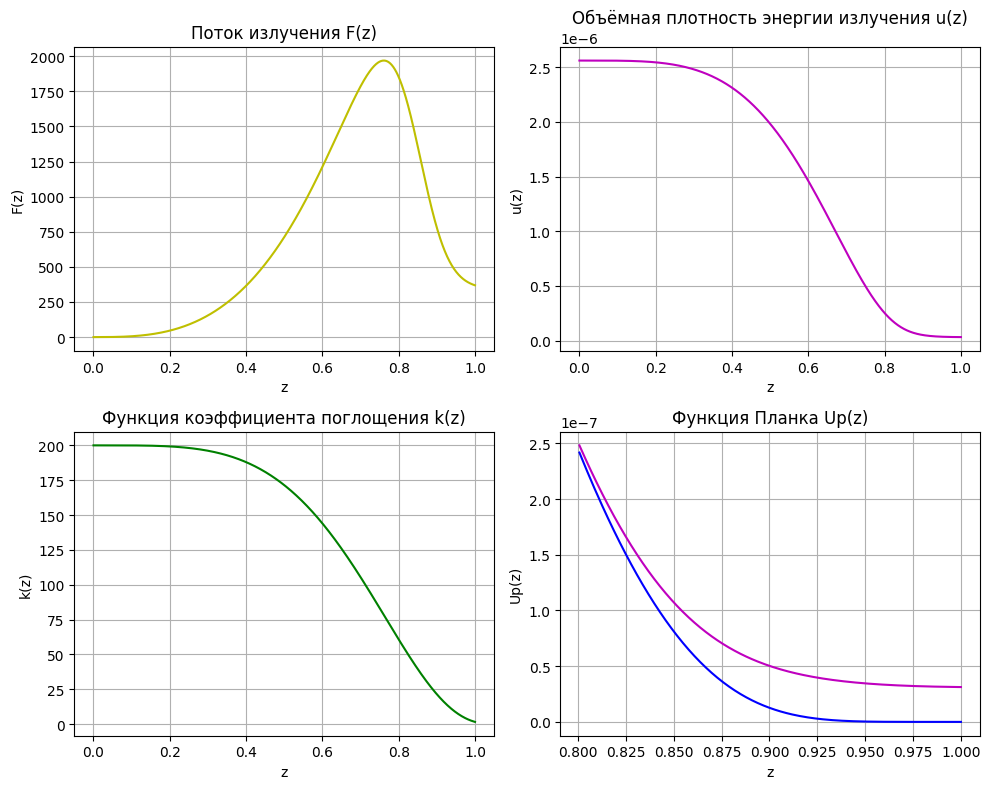

In [100]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(z, F, linestyle='-', color='y')
plt.title('Поток излучения F(z)')
plt.xlabel('z')
plt.ylabel('F(z)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(z, u, linestyle='-', color='m')
plt.title('Объёмная плотность энергии излучения u(z)')
plt.xlabel('z')
plt.ylabel('u(z)')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(z, k2(T(z)), linestyle='-', color='g')
plt.title('Функция коэффициента поглощения k(z)')
plt.xlabel('z')
plt.ylabel('k(z)')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(z[800:], Up2(z)[800:], linestyle='-', color='b')
plt.plot(z[800:], u[800:], linestyle='-', color='m')
plt.title('Функция Планка Up(z)')
plt.xlabel('z')
plt.ylabel('Up(z)')
plt.grid()


plt.tight_layout()
plt.show()